In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from __future__ import print_function
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier
from keras import backend as K
from keras.applications.vgg16 import VGG16
from sklearn.datasets import fetch_mldata
from sklearn import tree
from sklearn import metrics
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn import svm
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import glob
import platform
import time
from PIL import Image
from skimage.feature import hog
import numpy as np
import os
import joblib
from sklearn.svm import LinearSVC
import shutil
import sys

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2



Using TensorFlow backend.


In [2]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)
   

In [3]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  
    # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


In [4]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)
        print('++++++++++++++++++++++++++++++++++++++++++++++1')
#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection



class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        print('++++++++++++++++++++++++++++++++++++++++++++++')
        print(str(np.argsort(e)[::-1]))
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        print('++++++++++++++++++++++++++++++++++++++++++++++2')
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection


In [5]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [6]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

In [7]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):
        
        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)





In [8]:
def areas(lengths,choice_str,model):
    sum = 0.
    i = 0
    k=10
    #print(lengths,ks)
    for length in lengths:
        lengthhere = lengths[i]
        if i == 0:
            sum = sum + lengthhere*k/2
        else:
            sum = sum + (lengthhere+lengthhere)*k/2
        i += 1
    #print("The whole area is : 50,000")
    print("Airplane & car "+choice_str+" "+model+": The area below this line is: %.2f"%sum)
    
    

In [9]:
def getdataset(choice):
    if os.path.exists('bottleneck_features_test.npy') and choice == "Pretrained":
        choice ='Pretrained_repeat'
    print("Geting data now")
    print("The data you chose is "+choice)
    classifications=['airplane','car']
    train_data_dir = 'rawdata/train/'
    validation_data_dir = 'rawdata/test/'
    
    nb_train_samples = trainset_size
    nb_validation_samples = testset_size

    df_train = []
    y_train_full=[]
    images = os.listdir(train_data_dir)
    for classification in classifications:
        imagePaths = [f for f in glob.glob(train_data_dir+classification+'/'+'*.jpg')]
        #here will take one min
        for img in imagePaths:
            img_data = load_img(img ,target_size=(150, 150))
            img_data_array = img_to_array(img_data)
            #print(img_data_array.shape)#img_data_array is (150,150,3)
            if choice == 'Raw':
                #will get (150*150*3)
                img_data_flat = img_data_array.reshape(img_data_array.shape[0]*img_data_array.shape[1]*img_data_array.shape[2])
                #print(img_data_flat.shape)
            if choice == 'HOG' :
                #will get (150,150)
                img_data_flat=(img_data_array[:, :, 0] * 0.2989 + img_data_array[:, :, 1] * 0.5870 + img_data_array[:, :, 2] * 0.1140)/255.0
                #print(img_data_flat.shape)
            if choice == 'Pretrained' or choice == 'Pretrained_repeat':
                #will get is (150,150,3)
                img_data_flat= img_data_array
                #print(img_data_flat.shape)
            df_train.append(img_data_flat)
            #print(classification)
            if classification == "airplane":
                y_train_full.append(0)
            if classification == "car":
                y_train_full.append(1)
    #print(y_train_full)
            

    df_val = []
    y_test = []
    images = os.listdir(validation_data_dir)
    for classification in classifications:
        imagePaths = [f for f in glob.glob(validation_data_dir+classification+'/'+'*.jpg')]
        for img in imagePaths:
            img_data = load_img(img ,target_size=(150, 150))
            img_data_array = img_to_array(img_data)
            if choice == 'Raw':
                #will get (150*150*3)
                img_data_flat = img_data_array.reshape(img_data_array.shape[0]*img_data_array.shape[1]*img_data_array.shape[2])
                #print(img_data_flat.shape)
            if choice == 'HOG' :
                #will get (150,150)
                img_data_flat=(img_data_array[:, :, 0] * 0.2989 + img_data_array[:, :, 1] * 0.5870 + img_data_array[:, :, 2] * 0.1140)/255.0
                #print(img_data_flat.shape)
            if choice == 'Pretrained' or choice == 'Pretrained_repeat':
                #will get is (150,150,3)
                img_data_flat= img_data_array
                #print(img_data_flat.shape)
            df_val.append(img_data_flat)
            if classification == "airplane":
                    y_test.append(0)
            if classification == "car":
                    y_test.append(1)
            #print(y_train_full)

    #This will run for 10second
    X_train_full = np.concatenate([arr[np.newaxis] for arr in df_train]).astype('float32')
    X_test = np.concatenate([arr[np.newaxis] for arr in df_val]).astype('float32')

    #将list 转成np，否则会有报错
    y_train_full=np.array(y_train_full)
    y_test=np.array(y_test)

    if choice =='HOG':
        X_test_new=[]
        X_train_new=[]
        for num in range(0,trainset_size):
            fd = hog(X_train_full[num], orientations=12,block_norm='L1', pixels_per_cell=[8, 8], cells_per_block=[4, 4], visualize=False,transform_sqrt=False
                    )
            X_train_new.append(fd)

        for num in range(0,testset_size):
            fd = hog(X_test[num], orientations=12,block_norm='L1', pixels_per_cell=[8, 8], cells_per_block=[4, 4], visualize=False,
                             transform_sqrt=True)
            X_test_new.append(fd)

        X_train_full=np.array(X_train_new)
        X_test=np.array(X_test_new)

    if choice == 'Pretrained':
        model = applications.VGG16(include_top=False, weights='imagenet')
        last_layer = Model(inputs=model.input, outputs=model.get_layer('block5_pool').output)

        start = time.clock()
        print("Process data though the pretrained mdoel(train set), it will last for about 8 mins")
        features = last_layer.predict(X_train_full)
        elapsed = (time.clock() - start)
        print("(should about 8 mins)Time used:",elapsed)

        start = time.clock()
        print("Process data though the pretrained mdoel(test set), it will last for about 2 mins")
        features_test = last_layer.predict(X_test)
        elapsed = (time.clock() - start)
        print("(should about 100second)Time used:",elapsed)

        X_train_full = features.reshape(trainset_size,-1)
        X_test=features_test.reshape(testset_size,-1)

        np.save('bottleneck_features_train.npy',X_train_full)
        np.save('bottleneck_features_test.npy',X_test)

    if choice == 'Pretrained' or choice == 'Pretrained_repeat':
        X_train_full=np.load('bottleneck_features_train.npy')
        X_test=np.load('bottleneck_features_test.npy')
    #print(y_train_full)
        
        
    print("Got all data now, here is the shape of the data")
    print("X_train_full shape: "+str(X_train_full.shape))
    print("y_train_full shape: "+str(y_train_full.shape))
    print("X_test shape: "+str(X_test.shape))
    print("y_test shape: "+str(y_test.shape))
        
    return (X_train_full,y_train_full,X_test,y_test)



In [24]:
#'500''1294'
max_queried = 500
Ks = [10]

#True means will save, False means will not save 
save_file=True

#'Raw''HOG''Pretrained'
choices=['HOG']

#'RfModel''LogModel''SvmModel'
models = [LogModel] 

#'RandomSelection''MarginSamplingSelection''EntropySelection'
selection_functions = [RandomSelection, MarginSamplingSelection,EntropySelection] 



In [25]:
trainset_size = 1295
testset_size = 400

choices_str=choices

Ks_str = ['10'] 

models_str=[]
for model in models:
    models_str.append( model.__name__) 

selection_functions_str=[]
for selection_function in selection_functions:
    selection_functions_str.append( selection_function.__name__) 

stopped_at = -1 
#the data should be put in two dir rowdata/train/ and rowdata/test/
#data should be named as A.num.jpg 

In [27]:

import time
 
start = time.clock()
 
#get the dataset here


  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for choice in choices:
        if choice not in d:
            d[choice] = {}
            (X_train_full,y_train_full,X_test,y_test)=getdataset(choice)
        for model_object in models:
            if model_object.__name__ not in d[choice]:
                d[choice][model_object.__name__] = {}
            for selection_function in selection_functions:
                if selection_function.__name__ not in d[choice][model_object.__name__]:
                    d[choice][model_object.__name__][selection_function.__name__] = {}

                for k in Ks:
                    d[choice][model_object.__name__][selection_function.__name__][str(k)] = []           

                    for i in range(0, repeats):
                        count+=1
                        if count >= contfrom:
                            print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                            alg = TheAlgorithm(k, 
                                               model_object, 
                                               selection_function
                                               )
                            alg.run(X_train_full, y_train_full, X_test, y_test)
                            d[choice][model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                            if count % 5 == 0:
                                print(json.dumps(d, indent=2, sort_keys=True))
                            print ()
                            print ('---------------------------- FINISHED ---------------------------')
                            print ()
    return d



d = {}
# print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, 1, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print('1')
print(results)




elapsed = (time.clock() - start)
print("Time used:",elapsed)

stopping at: 500
Geting data now
The data you chose is HOG
Got all data now, here is the shape of the data
X_train_full shape: (1295, 43200)
y_train_full shape: (1295,)
X_test shape: (400, 43200)
y_test shape: (400,)
Count = 1, using model = LogModel, selection_function = RandomSelection, k = 10, iteration = 0.

initial random chosen samples (10,)
initial train set: (10, 43200) (10,) unique(labels): [3 7] [0 1]
val set: (1285, 43200) (1285,) (10,)

Train set: (10, 43200) y: (10,)
Val   set: (1285, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (400,)
Example run in 0.150 s 

Accuracy rate for 76.750000 
Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', 

val set: (1225, 43200) (1225,)

Train set: (70, 43200) y: (70,)
Val   set: (1225, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 7
--------------------------------
y-test set: (400,)
Example run in 0.498 s 

Accuracy rate for 96.500000 
Classification report for classifier LogisticRegression(C=0.7142857142857143, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       200
           1       0.95      0.98      0.97       200

   micro avg       0.96      0.96      0.96       400
   macro avg       0.97      0.96      0.96       400
weighted avg       0.97      0.96      0.96       400


Confusion matrix:
[[190  10]


trainset before (130, 43200) (130,)
trainset after (140, 43200) (140,)
updated train set: (140, 43200) (140,) unique(labels): [60 80] [0 1]
val set: (1155, 43200) (1155,)

Train set: (140, 43200) y: (140,)
Val   set: (1155, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 14
--------------------------------
y-test set: (400,)
Example run in 0.785 s 

Accuracy rate for 95.500000 
Classification report for classifier LogisticRegression(C=0.35714285714285715, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       200
           1       0.95      0.95      0.95       200

   micro avg       0.95      0.95      0.95      

--------------------------------
Iteration: 20
--------------------------------
y-test set: (400,)
Example run in 1.192 s 

Accuracy rate for 95.500000 
Classification report for classifier LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       200
           1       0.95      0.96      0.96       200

   micro avg       0.95      0.95      0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400


Confusion matrix:
[[189  11]
 [  7 193]]
--------------------------------
val predicted: (1095,) [0 0 0 ... 1 1 1]
probabilities: (1095, 2) 
 [0 0 0 ... 1 1 1]
++++++++++++++++++++++++++++++++++++

trainset before (260, 43200) (260,)
trainset after (270, 43200) (270,)
updated train set: (270, 43200) (270,) unique(labels): [110 160] [0 1]
val set: (1025, 43200) (1025,)

Train set: (270, 43200) y: (270,)
Val   set: (1025, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 27
--------------------------------
y-test set: (400,)
Example run in 1.410 s 

Accuracy rate for 93.750000 
Classification report for classifier LogisticRegression(C=0.18518518518518517, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       200
           1       0.91      0.96      0.94       200

   micro avg       0.94      0.94      0.94    

trainset before (300, 43200) (300,)
trainset after (310, 43200) (310,)
updated train set: (310, 43200) (310,) unique(labels): [124 186] [0 1]
val set: (985, 43200) (985,)

Train set: (310, 43200) y: (310,)
Val   set: (985, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 31
--------------------------------
y-test set: (400,)
Example run in 1.419 s 

Accuracy rate for 93.500000 
Classification report for classifier LogisticRegression(C=0.16129032258064516, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       200
           1       0.92      0.95      0.94       200

   micro avg       0.94      0.94      0.94       

trainset before (320, 43200) (320,)
trainset after (330, 43200) (330,)
updated train set: (330, 43200) (330,) unique(labels): [131 199] [0 1]
val set: (965, 43200) (965,)

Train set: (330, 43200) y: (330,)
Val   set: (965, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 33
--------------------------------
y-test set: (400,)
Example run in 1.701 s 

Accuracy rate for 92.500000 
Classification report for classifier LogisticRegression(C=0.15151515151515152, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       200
           1       0.90      0.95      0.93       200

   micro avg       0.93      0.93      0.93       

trainset before (340, 43200) (340,)
trainset after (350, 43200) (350,)
updated train set: (350, 43200) (350,) unique(labels): [139 211] [0 1]
val set: (945, 43200) (945,)

Train set: (350, 43200) y: (350,)
Val   set: (945, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 35
--------------------------------
y-test set: (400,)
Example run in 1.583 s 

Accuracy rate for 93.500000 
Classification report for classifier LogisticRegression(C=0.14285714285714285, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       200
           1       0.91      0.96      0.94       200

   micro avg       0.94      0.94      0.94       

trainset before (360, 43200) (360,)
trainset after (370, 43200) (370,)
updated train set: (370, 43200) (370,) unique(labels): [150 220] [0 1]
val set: (925, 43200) (925,)

Train set: (370, 43200) y: (370,)
Val   set: (925, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 37
--------------------------------
y-test set: (400,)
Example run in 1.665 s 

Accuracy rate for 93.750000 
Classification report for classifier LogisticRegression(C=0.13513513513513514, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       200
           1       0.92      0.95      0.94       200

   micro avg       0.94      0.94      0.94       

trainset before (380, 43200) (380,)
trainset after (390, 43200) (390,)
updated train set: (390, 43200) (390,) unique(labels): [159 231] [0 1]
val set: (905, 43200) (905,)

Train set: (390, 43200) y: (390,)
Val   set: (905, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 39
--------------------------------
y-test set: (400,)
Example run in 1.969 s 

Accuracy rate for 93.000000 
Classification report for classifier LogisticRegression(C=0.1282051282051282, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       200
           1       0.91      0.96      0.93       200

   micro avg       0.93      0.93      0.93       4

trainset before (400, 43200) (400,)
trainset after (410, 43200) (410,)
updated train set: (410, 43200) (410,) unique(labels): [170 240] [0 1]
val set: (885, 43200) (885,)

Train set: (410, 43200) y: (410,)
Val   set: (885, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 41
--------------------------------
y-test set: (400,)
Example run in 1.851 s 

Accuracy rate for 92.500000 
Classification report for classifier LogisticRegression(C=0.12195121951219512, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       200
           1       0.90      0.95      0.93       200

   micro avg       0.93      0.93      0.93       

trainset before (420, 43200) (420,)
trainset after (430, 43200) (430,)
updated train set: (430, 43200) (430,) unique(labels): [174 256] [0 1]
val set: (865, 43200) (865,)

Train set: (430, 43200) y: (430,)
Val   set: (865, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 43
--------------------------------
y-test set: (400,)
Example run in 1.926 s 

Accuracy rate for 93.500000 
Classification report for classifier LogisticRegression(C=0.11627906976744186, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       200
           1       0.91      0.96      0.94       200

   micro avg       0.94      0.94      0.94       

trainset before (440, 43200) (440,)
trainset after (450, 43200) (450,)
updated train set: (450, 43200) (450,) unique(labels): [184 266] [0 1]
val set: (845, 43200) (845,)

Train set: (450, 43200) y: (450,)
Val   set: (845, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 45
--------------------------------
y-test set: (400,)
Example run in 2.005 s 

Accuracy rate for 93.250000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       200
           1       0.91      0.96      0.93       200

   micro avg       0.93      0.93      0.93       4

trainset before (460, 43200) (460,)
trainset after (470, 43200) (470,)
updated train set: (470, 43200) (470,) unique(labels): [194 276] [0 1]
val set: (825, 43200) (825,)

Train set: (470, 43200) y: (470,)
Val   set: (825, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 47
--------------------------------
y-test set: (400,)
Example run in 2.103 s 

Accuracy rate for 93.250000 
Classification report for classifier LogisticRegression(C=0.10638297872340426, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       200
           1       0.91      0.96      0.93       200

   micro avg       0.93      0.93      0.93       

trainset before (480, 43200) (480,)
trainset after (490, 43200) (490,)
updated train set: (490, 43200) (490,) unique(labels): [200 290] [0 1]
val set: (805, 43200) (805,)

Train set: (490, 43200) y: (490,)
Val   set: (805, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 49
--------------------------------
y-test set: (400,)
Example run in 2.184 s 

Accuracy rate for 93.250000 
Classification report for classifier LogisticRegression(C=0.10204081632653061, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       200
           1       0.91      0.96      0.93       200

   micro avg       0.93      0.93      0.93       

val predicted: (1275,) [0 0 0 ... 0 1 1]
probabilities: (1275, 2) 
 [0 0 0 ... 0 1 1]
++++++++++++++++++++++++++++++++++++++++++++++2
trainset before (20, 43200) (20,)
trainset after (30, 43200) (30,)
updated train set: (30, 43200) (30,) unique(labels): [ 6 24] [0 1]
val set: (1265, 43200) (1265,)

Train set: (30, 43200) y: (30,)
Val   set: (1265, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 3
--------------------------------
y-test set: (400,)
Example run in 0.361 s 

Accuracy rate for 72.500000 
Classification report for classifier LogisticRegression(C=1.6666666666666667, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       1.00      0.45 

--------------------------------
Iteration: 9
--------------------------------
y-test set: (400,)
Example run in 0.689 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.5555555555555556, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       200
           1       0.95      0.97      0.96       200

   micro avg       0.96      0.96      0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400


Confusion matrix:
[[189  11]
 [  5 195]]
--------------------------------
val predicted: (1205,) [0 0 0 ... 1 1 1]
probabilities: (1205, 2) 
 [0 0 0 ... 1 1 1]
+++++++++++++++++++++++

trainset before (150, 43200) (150,)
trainset after (160, 43200) (160,)
updated train set: (160, 43200) (160,) unique(labels): [ 48 112] [0 1]
val set: (1135, 43200) (1135,)

Train set: (160, 43200) y: (160,)
Val   set: (1135, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 16
--------------------------------
y-test set: (400,)
Example run in 0.984 s 

Accuracy rate for 97.500000 
Classification report for classifier LogisticRegression(C=0.3125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.97      0.97       200

   micro avg       0.97      0.97      0.97       400
   mac

--------------------------------
Iteration: 22
--------------------------------
y-test set: (400,)
Example run in 1.438 s 

Accuracy rate for 97.000000 
Classification report for classifier LogisticRegression(C=0.22727272727272727, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       200
           1       0.97      0.97      0.97       200

   micro avg       0.97      0.97      0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400


Confusion matrix:
[[193   7]
 [  5 195]]
--------------------------------
val predicted: (1075,) [0 0 0 ... 1 1 1]
probabilities: (1075, 2) 
 [0 0 0 ... 1 1 1]
+++++++++++++++++++++

trainset before (280, 43200) (280,)
trainset after (290, 43200) (290,)
updated train set: (290, 43200) (290,) unique(labels): [ 77 213] [0 1]
val set: (1005, 43200) (1005,)

Train set: (290, 43200) y: (290,)
Val   set: (1005, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 29
--------------------------------
y-test set: (400,)
Example run in 1.342 s 

Accuracy rate for 97.000000 
Classification report for classifier LogisticRegression(C=0.1724137931034483, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.96      0.97       200

   micro avg       0.97      0.97      0.97     

trainset before (310, 43200) (310,)
trainset after (320, 43200) (320,)
updated train set: (320, 43200) (320,) unique(labels): [ 82 238] [0 1]
val set: (975, 43200) (975,)

Train set: (320, 43200) y: (320,)
Val   set: (975, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 32
--------------------------------
y-test set: (400,)
Example run in 2.040 s 

Accuracy rate for 97.500000 
Classification report for classifier LogisticRegression(C=0.15625, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       200
           1       0.97      0.98      0.98       200

   micro avg       0.97      0.97      0.97       400
   macro

trainset before (330, 43200) (330,)
trainset after (340, 43200) (340,)
updated train set: (340, 43200) (340,) unique(labels): [ 86 254] [0 1]
val set: (955, 43200) (955,)

Train set: (340, 43200) y: (340,)
Val   set: (955, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 34
--------------------------------
y-test set: (400,)
Example run in 2.168 s 

Accuracy rate for 97.250000 
Classification report for classifier LogisticRegression(C=0.14705882352941177, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.97      0.97       200

   micro avg       0.97      0.97      0.97       

trainset before (350, 43200) (350,)
trainset after (360, 43200) (360,)
updated train set: (360, 43200) (360,) unique(labels): [ 88 272] [0 1]
val set: (935, 43200) (935,)

Train set: (360, 43200) y: (360,)
Val   set: (935, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 36
--------------------------------
y-test set: (400,)
Example run in 2.083 s 

Accuracy rate for 97.000000 
Classification report for classifier LogisticRegression(C=0.1388888888888889, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.96      0.97       200

   micro avg       0.97      0.97      0.97       4

trainset before (370, 43200) (370,)
trainset after (380, 43200) (380,)
updated train set: (380, 43200) (380,) unique(labels): [ 91 289] [0 1]
val set: (915, 43200) (915,)

Train set: (380, 43200) y: (380,)
Val   set: (915, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 38
--------------------------------
y-test set: (400,)
Example run in 2.172 s 

Accuracy rate for 96.250000 
Classification report for classifier LogisticRegression(C=0.13157894736842105, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       200
           1       0.97      0.95      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (390, 43200) (390,)
trainset after (400, 43200) (400,)
updated train set: (400, 43200) (400,) unique(labels): [101 299] [0 1]
val set: (895, 43200) (895,)

Train set: (400, 43200) y: (400,)
Val   set: (895, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 40
--------------------------------
y-test set: (400,)
Example run in 2.569 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       400
   macro a

trainset before (410, 43200) (410,)
trainset after (420, 43200) (420,)
updated train set: (420, 43200) (420,) unique(labels): [111 309] [0 1]
val set: (875, 43200) (875,)

Train set: (420, 43200) y: (420,)
Val   set: (875, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 42
--------------------------------
y-test set: (400,)
Example run in 1.877 s 

Accuracy rate for 96.500000 
Classification report for classifier LogisticRegression(C=0.11904761904761904, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       200
           1       0.97      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (430, 43200) (430,)
trainset after (440, 43200) (440,)
updated train set: (440, 43200) (440,) unique(labels): [111 329] [0 1]
val set: (855, 43200) (855,)

Train set: (440, 43200) y: (440,)
Val   set: (855, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 44
--------------------------------
y-test set: (400,)
Example run in 2.235 s 

Accuracy rate for 96.500000 
Classification report for classifier LogisticRegression(C=0.11363636363636363, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       200
           1       0.97      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (450, 43200) (450,)
trainset after (460, 43200) (460,)
updated train set: (460, 43200) (460,) unique(labels): [115 345] [0 1]
val set: (835, 43200) (835,)

Train set: (460, 43200) y: (460,)
Val   set: (835, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 46
--------------------------------
y-test set: (400,)
Example run in 2.623 s 

Accuracy rate for 95.000000 
Classification report for classifier LogisticRegression(C=0.10869565217391304, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       200
           1       0.95      0.95      0.95       200

   micro avg       0.95      0.95      0.95       

trainset before (470, 43200) (470,)
trainset after (480, 43200) (480,)
updated train set: (480, 43200) (480,) unique(labels): [120 360] [0 1]
val set: (815, 43200) (815,)

Train set: (480, 43200) y: (480,)
Val   set: (815, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 48
--------------------------------
y-test set: (400,)
Example run in 2.448 s 

Accuracy rate for 95.500000 
Classification report for classifier LogisticRegression(C=0.10416666666666667, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       200
           1       0.96      0.95      0.95       200

   micro avg       0.95      0.95      0.95       

trainset before (490, 43200) (490,)
trainset after (500, 43200) (500,)
updated train set: (500, 43200) (500,) unique(labels): [126 374] [0 1]
val set: (795, 43200) (795,)

Train set: (500, 43200) y: (500,)
Val   set: (795, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 50
--------------------------------
y-test set: (400,)
Example run in 2.527 s 

Accuracy rate for 95.250000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       200
           1       0.95      0.95      0.95       200

   micro avg       0.95      0.95      0.95       400
   macro avg

trainset before (50, 43200) (50,)
trainset after (60, 43200) (60,)
updated train set: (60, 43200) (60,) unique(labels): [23 37] [0 1]
val set: (1235, 43200) (1235,)

Train set: (60, 43200) y: (60,)
Val   set: (1235, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 6
--------------------------------
y-test set: (400,)
Example run in 0.486 s 

Accuracy rate for 97.000000 
Classification report for classifier LogisticRegression(C=0.8333333333333334, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.96      0.97       200

   micro avg       0.97      0.97      0.97       400
   ma

val set: (1175, 43200) (1175,)

Train set: (120, 43200) y: (120,)
Val   set: (1175, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 12
--------------------------------
y-test set: (400,)
Example run in 0.692 s 

Accuracy rate for 96.250000 
Classification report for classifier LogisticRegression(C=0.4166666666666667, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400


Confusion matrix:
[[192   

--------------------------------
Iteration: 18
--------------------------------
y-test set: (400,)
Example run in 0.983 s 

Accuracy rate for 97.000000 
Classification report for classifier LogisticRegression(C=0.2777777777777778, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       200
           1       0.97      0.97      0.97       200

   micro avg       0.97      0.97      0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400


Confusion matrix:
[[193   7]
 [  5 195]]
--------------------------------
val predicted: (1115,) [0 0 0 ... 1 1 1]
probabilities: (1115, 2) 
 [0 0 0 ... 1 1 1]
++++++++++++++++++++++

trainset before (240, 43200) (240,)
trainset after (250, 43200) (250,)
updated train set: (250, 43200) (250,) unique(labels): [ 71 179] [0 1]
val set: (1045, 43200) (1045,)

Train set: (250, 43200) y: (250,)
Val   set: (1045, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 25
--------------------------------
y-test set: (400,)
Example run in 1.643 s 

Accuracy rate for 97.500000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.97      0.97       200

   micro avg       0.97      0.97      0.97       400
   macro 

trainset before (300, 43200) (300,)
trainset after (310, 43200) (310,)
updated train set: (310, 43200) (310,) unique(labels): [ 85 225] [0 1]
val set: (985, 43200) (985,)

Train set: (310, 43200) y: (310,)
Val   set: (985, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 31
--------------------------------
y-test set: (400,)
Example run in 2.095 s 

Accuracy rate for 96.500000 
Classification report for classifier LogisticRegression(C=0.16129032258064516, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       200
           1       0.96      0.97      0.97       200

   micro avg       0.96      0.96      0.96       

trainset before (310, 43200) (310,)
trainset after (320, 43200) (320,)
updated train set: (320, 43200) (320,) unique(labels): [ 86 234] [0 1]
val set: (975, 43200) (975,)

Train set: (320, 43200) y: (320,)
Val   set: (975, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 32
--------------------------------
y-test set: (400,)
Example run in 2.132 s 

Accuracy rate for 96.250000 
Classification report for classifier LogisticRegression(C=0.15625, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       200
           1       0.96      0.97      0.96       200

   micro avg       0.96      0.96      0.96       400
   macro

trainset before (320, 43200) (320,)
trainset after (330, 43200) (330,)
updated train set: (330, 43200) (330,) unique(labels): [ 86 244] [0 1]
val set: (965, 43200) (965,)

Train set: (330, 43200) y: (330,)
Val   set: (965, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 33
--------------------------------
y-test set: (400,)
Example run in 2.100 s 

Accuracy rate for 97.000000 
Classification report for classifier LogisticRegression(C=0.15151515151515152, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.96      0.97       200

   micro avg       0.97      0.97      0.97       

trainset before (330, 43200) (330,)
trainset after (340, 43200) (340,)
updated train set: (340, 43200) (340,) unique(labels): [ 90 250] [0 1]
val set: (955, 43200) (955,)

Train set: (340, 43200) y: (340,)
Val   set: (955, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 34
--------------------------------
y-test set: (400,)
Example run in 2.273 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.14705882352941177, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.95      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (340, 43200) (340,)
trainset after (350, 43200) (350,)
updated train set: (350, 43200) (350,) unique(labels): [ 91 259] [0 1]
val set: (945, 43200) (945,)

Train set: (350, 43200) y: (350,)
Val   set: (945, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 35
--------------------------------
y-test set: (400,)
Example run in 2.210 s 

Accuracy rate for 96.250000 
Classification report for classifier LogisticRegression(C=0.14285714285714285, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (350, 43200) (350,)
trainset after (360, 43200) (360,)
updated train set: (360, 43200) (360,) unique(labels): [ 93 267] [0 1]
val set: (935, 43200) (935,)

Train set: (360, 43200) y: (360,)
Val   set: (935, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 36
--------------------------------
y-test set: (400,)
Example run in 2.064 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.1388888888888889, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       4

trainset before (360, 43200) (360,)
trainset after (370, 43200) (370,)
updated train set: (370, 43200) (370,) unique(labels): [ 95 275] [0 1]
val set: (925, 43200) (925,)

Train set: (370, 43200) y: (370,)
Val   set: (925, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 37
--------------------------------
y-test set: (400,)
Example run in 1.919 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.13513513513513514, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (370, 43200) (370,)
trainset after (380, 43200) (380,)
updated train set: (380, 43200) (380,) unique(labels): [ 99 281] [0 1]
val set: (915, 43200) (915,)

Train set: (380, 43200) y: (380,)
Val   set: (915, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 38
--------------------------------
y-test set: (400,)
Example run in 1.975 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.13157894736842105, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (380, 43200) (380,)
trainset after (390, 43200) (390,)
updated train set: (390, 43200) (390,) unique(labels): [101 289] [0 1]
val set: (905, 43200) (905,)

Train set: (390, 43200) y: (390,)
Val   set: (905, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 39
--------------------------------
y-test set: (400,)
Example run in 2.003 s 

Accuracy rate for 97.000000 
Classification report for classifier LogisticRegression(C=0.1282051282051282, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.97      0.97       200

   micro avg       0.97      0.97      0.97       4

trainset before (390, 43200) (390,)
trainset after (400, 43200) (400,)
updated train set: (400, 43200) (400,) unique(labels): [105 295] [0 1]
val set: (895, 43200) (895,)

Train set: (400, 43200) y: (400,)
Val   set: (895, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 40
--------------------------------
y-test set: (400,)
Example run in 2.061 s 

Accuracy rate for 96.250000 
Classification report for classifier LogisticRegression(C=0.125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       400
   macro a

trainset before (400, 43200) (400,)
trainset after (410, 43200) (410,)
updated train set: (410, 43200) (410,) unique(labels): [108 302] [0 1]
val set: (885, 43200) (885,)

Train set: (410, 43200) y: (410,)
Val   set: (885, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 41
--------------------------------
y-test set: (400,)
Example run in 2.089 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.12195121951219512, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (410, 43200) (410,)
trainset after (420, 43200) (420,)
updated train set: (420, 43200) (420,) unique(labels): [110 310] [0 1]
val set: (875, 43200) (875,)

Train set: (420, 43200) y: (420,)
Val   set: (875, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 42
--------------------------------
y-test set: (400,)
Example run in 1.893 s 

Accuracy rate for 95.750000 
Classification report for classifier LogisticRegression(C=0.11904761904761904, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (420, 43200) (420,)
trainset after (430, 43200) (430,)
updated train set: (430, 43200) (430,) unique(labels): [114 316] [0 1]
val set: (865, 43200) (865,)

Train set: (430, 43200) y: (430,)
Val   set: (865, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 43
--------------------------------
y-test set: (400,)
Example run in 2.479 s 

Accuracy rate for 96.000000 
Classification report for classifier LogisticRegression(C=0.11627906976744186, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (430, 43200) (430,)
trainset after (440, 43200) (440,)
updated train set: (440, 43200) (440,) unique(labels): [117 323] [0 1]
val set: (855, 43200) (855,)

Train set: (440, 43200) y: (440,)
Val   set: (855, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 44
--------------------------------
y-test set: (400,)
Example run in 2.529 s 

Accuracy rate for 96.250000 
Classification report for classifier LogisticRegression(C=0.11363636363636363, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.96      0.96      0.96       200

   micro avg       0.96      0.96      0.96       

trainset before (440, 43200) (440,)
trainset after (450, 43200) (450,)
updated train set: (450, 43200) (450,) unique(labels): [120 330] [0 1]
val set: (845, 43200) (845,)

Train set: (450, 43200) y: (450,)
Val   set: (845, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 45
--------------------------------
y-test set: (400,)
Example run in 2.561 s 

Accuracy rate for 95.500000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       200
           1       0.95      0.96      0.96       200

   micro avg       0.95      0.95      0.95       4

val set: (835, 43200) (835,)

Train set: (460, 43200) y: (460,)
Val   set: (835, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 46
--------------------------------
y-test set: (400,)
Example run in 2.332 s 

Accuracy rate for 94.750000 
Classification report for classifier LogisticRegression(C=0.10869565217391304, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       200
           1       0.94      0.95      0.95       200

   micro avg       0.95      0.95      0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400


Confusion matrix:
[[188  12]

--------------------------------
Iteration: 47
--------------------------------
y-test set: (400,)
Example run in 2.382 s 

Accuracy rate for 95.500000 
Classification report for classifier LogisticRegression(C=0.10638297872340426, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       200
           1       0.96      0.95      0.95       200

   micro avg       0.95      0.95      0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400


Confusion matrix:
[[192   8]
 [ 10 190]]
--------------------------------
val predicted: (825,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

trainset before (480, 43200) (480,)
trainset after (490, 43200) (490,)
updated train set: (490, 43200) (490,) unique(labels): [127 363] [0 1]
val set: (805, 43200) (805,)

Train set: (490, 43200) y: (490,)
Val   set: (805, 43200)
Test  set: (400, 43200)
training multinomial logistic regression
--------------------------------
Iteration: 49
--------------------------------
y-test set: (400,)
Example run in 2.494 s 

Accuracy rate for 94.250000 
Classification report for classifier LogisticRegression(C=0.10204081632653061, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       200
           1       0.94      0.94      0.94       200

   micro avg       0.94      0.94      0.94       

In [26]:
print(d)

{'Raw': {'SvmModel': {'RandomSelection': {'10': [[59.5, 67.25, 64.0, 67.75, 70.75, 73.75, 74.5, 72.75, 69.75, 71.25, 72.5, 71.5, 72.75, 72.75, 73.0, 73.25, 73.25, 72.75, 73.25, 73.75, 74.75, 73.75, 73.5, 72.25, 72.25, 72.5, 73.25, 73.75, 74.0, 74.5, 74.25, 75.25, 76.0, 76.25, 76.25, 76.25, 75.5, 75.5, 75.5, 75.75, 76.0, 75.75, 76.0, 76.25, 75.75, 75.25, 75.0, 75.25, 75.5, 75.25]]}, 'MarginSamplingSelection': {'10': [[75.5, 74.75, 81.5, 78.5, 78.25, 80.0, 83.25, 85.25, 83.0, 85.5, 81.0, 84.75, 83.0, 83.75, 85.5, 84.5, 83.75, 83.25, 83.5, 83.25, 83.5, 84.25, 84.0, 84.0, 84.0, 85.25, 85.5, 85.75, 85.0, 85.0, 85.0, 85.0, 84.75, 84.75, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.5, 84.75, 84.75, 84.75]]}, 'EntropySelection': {'10': [[61.75000000000001, 75.25, 73.25, 72.0, 74.5, 77.25, 80.25, 81.25, 81.5, 80.5, 81.0, 81.25, 80.0, 85.75, 86.75, 87.0, 87.25, 86.75, 86.75, 86.0, 86.75, 85.5, 85.75, 86.0, 85.5, 86.25, 85.75, 85.75, 86.0, 85.5, 85.0, 85.0, 84.75, 84

Airplane & car HOG LogModel: The area below this line is: 46426.25
Airplane & car HOG LogModel: The area below this line is: 47458.75
Airplane & car HOG LogModel: The area below this line is: 47413.75


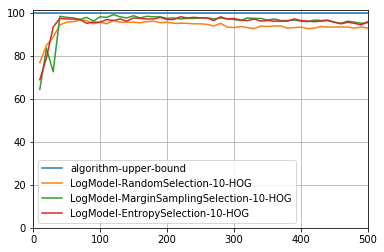

In [28]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats, lowest_y):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for choice_str in choices_str:
        for model_object in models:
          for selection_function in selection_functions:
            for idx, k in enumerate(Ks):
                x = np.arange(float(Ks[idx]), max_queried + float(Ks[idx]), float(Ks[idx]))            
                filename =choice_str+'-'+ model_object + '-' +selection_function + '-' + "10"+'.npy'
                mean = np.array(dic[choice_str][model_object][selection_function][k][0])
                if(save_file==True):
                    np.save(filename,mean)
                ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k)+'-'+choice_str)
                areas(mean,choice_str,model_object)
    ax.legend()
    ax.set_xlim([0,500])
    ax.set_ylim([0,101])
    ax.grid(True)
    plt.show()



performance_plot(100, 
                 d,
                 models_str,
                 selection_functions_str , 
                 Ks_str, 
                 1,
                 90)

